In [7]:
from diffusers import StableDiffusionPipeline
import torch
from diffusers import DPMSolverMultistepScheduler
from PIL import Image
from diffusers import AutoencoderKL
from transformers import CLIPImageProcessor, CLIPModel

In [71]:
feature_extractor = CLIPImageProcessor.from_pretrained("laion/CLIP-ViT-B-32-laion2B-s34B-b79K")
clip_model = CLIPModel.from_pretrained("laion/CLIP-ViT-B-32-laion2B-s34B-b79K", torch_dtype=torch.float16)


`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


In [55]:
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"

"device: {}".format(device)

'device: cuda'

In [73]:
model_id = "runwayml/stable-diffusion-v1-5"

vae = AutoencoderKL.from_pretrained(
    "stabilityai/sd-vae-ft-mse", torch_dtype=torch.float16)


pipeline = StableDiffusionPipeline.from_pretrained(
    model_id,
    torch_dtype=torch.float16,
    custom_pipeline="clip_guided_stable_diffusion",
    feature_extractor=feature_extractor,
    clip_model=clip_model,
)
pipeline.enable_attention_slicing()

pipeline.vae = vae
pipeline.scheduler = DPMSolverMultistepScheduler.from_config(
    pipeline.scheduler.config)

vae.to(device)
pipeline.to(device)

Fetching 15 files: 100%|██████████| 15/15 [00:00<00:00, 107362.73it/s]
/home/meegan1/Projects/ML/StabilityDiffuser/.venv/lib/python3.10/site-packages/huggingface_hub/file_download.py:637: FutureWarning: `cached_download` is the legacy way to download files from the HF hub, please consider upgrading to `hf_hub_download`
  warnings.warn(


CLIPGuidedStableDiffusion {
  "_class_name": "CLIPGuidedStableDiffusion",
  "_diffusers_version": "0.14.0",
  "clip_model": [
    "transformers",
    "CLIPModel"
  ],
  "feature_extractor": [
    "transformers",
    "CLIPImageProcessor"
  ],
  "scheduler": [
    "diffusers",
    "PNDMScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

In [76]:
def get_inputs(prompt, batch_size=1):
    generator = torch.Generator(device).manual_seed(0)
    num_inference_steps = 20

    return {"prompt": prompt,
            "generator": generator,
            "num_inference_steps": num_inference_steps,
            "clip_guidance_scale": 50,
            "guidance_scale": 7.5,
            "num_cutouts": batch_size,
            "use_cutouts": False,
            }


def image_grid(imgs, rows=2, cols=2):
    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))

    for i, img in enumerate(imgs):
        grid.paste(img, box=(i % cols*w, i//cols*h))
    return grid


In [74]:
prompt = "chocolate bar in a field, ultrarealistic, photograph"
prompt += " 50mm portrait photography, hard rim lighting photography--beta --ar 2:3  --beta --upbeta"

prompt

'chocolate bar in a field, ultrarealistic, photograph 50mm portrait photography, hard rim lighting photography--beta --ar 2:3  --beta --upbeta'

100%|██████████| 20/20 [00:07<00:00,  2.86it/s]


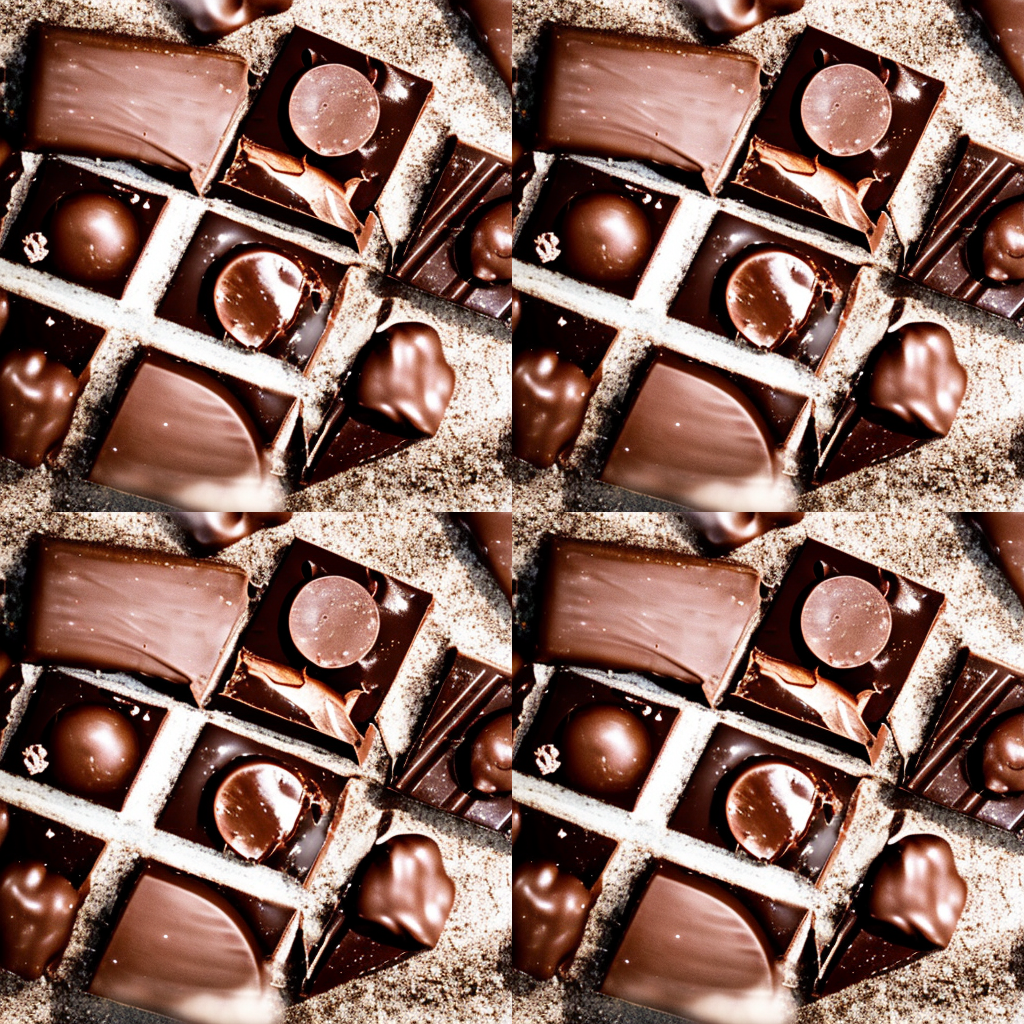

In [77]:
images = []

num_images = 4
for i in range(num_images):
  image = pipeline(**get_inputs(prompt=prompt, batch_size=num_images)).images[0]
  images.append(image)

image_grid(images)